Importing libraries required for this project

In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [1]:
#Path of the dataset
data_root = ('Dataset')

In [2]:
#Image size = (width,height)
IMAGE_SHAPE = (224, 224)

In [3]:
# Training directory
TRAINING_DATA_DIR = str(data_root)

In [4]:
#Parameters for scaling and train-validation split ratio
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

In [6]:
# Generating train and validation data

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset='validation',
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset='training',
shuffle=True,
target_size=IMAGE_SHAPE)

Found 264 images belonging to 2 classes.
Found 1058 images belonging to 2 classes.


In [7]:
# Creating batches of images for model training

for image_batch,label_batch in train_generator:
  break

image_batch.shape,label_batch.shape

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


((32, 224, 224, 3), (32, 2))

In [8]:
label_batch[:5]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [9]:
# Class Labels 
print (train_generator.class_indices)

{'Digital Camera': 0, 'Phone': 1}


In [10]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)

In [11]:
!cat labels.txt

Digital Camera
Phone

In [12]:
import tensorflow_hub as hub

In [13]:
# Creating custom model using keras layers and mobilenet pretrained layers

model = tf.keras.Sequential([
 hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 
 output_shape=[1280],
 trainable=False),
 tf.keras.layers.Dropout(0.4),
 tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
# Compilation of Model

optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
#Model fitting

hist = model.fit(
 train_generator, 
 epochs=100,
 verbose=1,
 validation_steps=val_steps_per_epoch).history

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.4150 - acc: 0.8053

34/34 [==============================] - 179s 5s/step - loss: 0.4150 - acc: 0.8053 - val_loss: 0.1549 - val_acc: 0.9508
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.1897 - acc: 0.9187

34/34 [==============================] - 33s 967ms/step - loss: 0.1897 - acc: 0.9187 - val_loss: 0.1036 - val_acc: 0.9697
Epoch 3/10
32/34 [===========================>..] - ETA: 1s - loss: 0.1486 - acc: 0.9376

KeyboardInterrupt: ignored

In [ ]:
#Saving the model to local files
tf.keras.models.save_model(model,'mobilenet_last_good_acc.h5')

In [ ]:
# Finding accuracy for validation dataset

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))

3/9 [=========>....................] - ETA: 7s - loss: 0.1257 - acc: 0.9688

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9/9 [==============================] - 8s 833ms/step - loss: 0.1005 - acc: 0.9697
Final loss: 0.10
Final accuracy: 96.97%


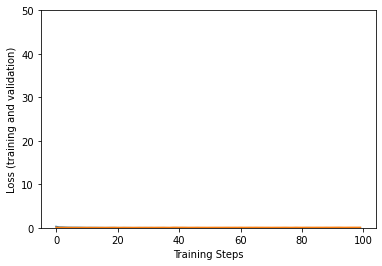

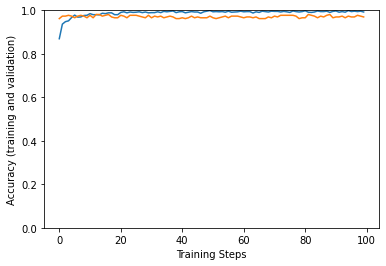

In [ ]:
# Plotting Loss and Accuracy

plt.figure()
plt.ylabel('Loss (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0,50])
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.figure()
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0,1])
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

In [20]:
# Loading the model
model = tf.keras.models.load_model("mobilenet_last_good_acc.h5",custom_objects={'KerasLayer':hub.KerasLayer})

In [29]:
import urllib.request
import PIL
import numpy as np
import matplotlib.pyplot as plt
# Image preprocessing required for model prediction

urllib.request.urlretrieve("https://images.jdmagicbox.com/quickquotes/images_main/canon-eos-eos-1300d-dslr-camera-body-with-dual-lens-ef-s-18-55-mm-is-ii-ef-s-55-250-mm-f4-5-6-is-ii-16-gb-sd-card-black-164374232-btxk4.jpg","sample.png")
img = PIL.Image.open("sample.png").resize((224,224))
test_img = np.array(img).reshape(-1,224,224,3)

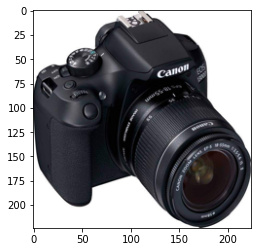

In [30]:
# Image from the url
plt.figure()
plt.imshow(img)
plt.show()

In [32]:
# Model Prediction 
make_predictions =model.predict(test_img)
print(make_predictions)

[[0.9734693  0.02653064]]


Here is the prediction array of probabilities.
There 97.34% chances of image containing class 0 that is digital camera.